# Thema 2 - Optimalisatie 
## Werkcollege 2


### Leerdoelen
In dit werkcollege.. 
* leer je afbeeldingen te analyseren, waaronder hoe een afbeelding digitaal werkt
* fit je een model aan complexe (afbeeldings-)data
* pas je brute force en line search methodes toe
* ontwikkel je een op maat gemaakte cost functie
* leer je de skimage library gebruiken

In de eerste les heb je gezien hoe je een model kunt bouwen om een model aan een reeks datapunten te fitten. Dit noemen we ook wel een regressieprobleem. 

In deze tweede les laten we je zien dat optimalisatie een breder toepassingsgebied heeft. In dit geval gaan we aan de slag met afbeeldingsdata. Maar in feite is elk probleem waarbij je door middel van het spelen met de parameters op zoek gaat naar de optimale instelling een geschikt onderwerp.

In [2]:
# De libraries voor deze les
import pandas as pd                       # pip install pandas
import numpy as np                        # pip install numpy
import pylab as plt                       # pip install matplotlib
from mpl_toolkits.mplot3d import Axes3D   # pip install matplotlib
from scipy.optimize import minimize, brute    # pip install scipy
from skimage import io, transform         # pip install scikit-image
from datetime import datetime
from numpy import sin, cos, pi, exp

import plotly.graph_objects as go         # pip install ipywidgets jupyter-dash plotly
                                          # jupyter labextension install @jupyter-widgets/jupyterlab-manager jupyterlab-plotly

### Business Understanding
We gaan aan de slag met het verwerken van afbeeldingsdata. Zoals je misschien weet bestaan afbeeldingen op een computer uit een rood, groen en blauwe kleur. Dit zijn de zogenaamde RGB waarden, die je ook op een computer vaak gebruikt. Zo is de RGB waarde (255,0,0) de kleur rood en is de waarde (255,255,255) de kleur wit.

Moderne camera's maken foto's die in een keer alle drie de kleuren registreren. Bij de uitvinding van de camera in het begin van de 19e eeuw was hier nog geen sprake van. De camera's registreerden niks meer dan licht en donker, waarmee ze alleen enkel zwartwit foto's wisten te schieten.

<figure>
    <img src="Boulevard_du_Temple_by_Daguerre.jpg" width=600 alt="Eerste foto met een persoon"/>
    <figcaption><i>Een zwartwit foto uit 1838. Dit is de oudste foto met een persoon er op. Zie ook <a href="https://en.wikipedia.org/wiki/History_of_photography">Wikipedia</a> voor meer informatie. </i></figcaption>
</figure>

De volgende doorbraak kwam met de ontwikkeling van kleurfilters. Door deze voor de lens te zetten konden losse foto's worden gemaakt van de roodtinten, de groentinten en de blauwtinten. Door deze foto's vervolgens tijdens het ontwikkelen te combineren, ontstond een kleurfoto. 

Een van de eerste fotografen die gebruik maakte van deze techniek was Sergei Mikhailovich Prokudin-Gorskii (1863-1944). Hij maakte tussen 1905 en 1915 een lange reis door het Russische Rijk. Op zijn reis maakte hij meer dan 2600 van dit soort RGB foto's. Je kunt de collectie <a href="https://www.loc.gov/collections/prokudin-gorskii/">hier</a> bekijken. 

<figure>
    <img src="master-pnp-prok-00100-00187a.jpg" width=900 alt="RGB foto"/><br />
    <img src="service-pnp-prokc-20100-20187v.jpg" width=300 alt="RGB foto"/>
    <figcaption><i>De rood, groen en blauw gefilterde foto's boven. Onder de gecombineerde foto. Foto uit 1905. <a href="https://www.loc.gov/item/2018679062/">https://www.loc.gov/item/2018679062/</a></i></figcaption>
</figure>

In de bovenstaande figuur zie je hoe drie van deze afbeeldingen gecombineerd worden tot één afbeelding. In deze les gaan wij dit ook doen voor een van zijn andere afbeeldingen. De complexiteit van het probleem zit in de onderlinge verschuiving van de afbeeldingen. Als we de rode afbeelding als de basis nemen, dan kan bijvoorbeeld de groene afbeelding 2 pixels omlaag geschoven zijn en de blauwe juist 4 pixels naar rechts. Het optimalisatieprobleem is dus het vinden van de verschuiving in de hoogte $x$ en breedte $y$ richtingen tussen twee afbeeldingen (let op, de naamgeving $x$ en $y$ is wat onlogisch, maar bewust om in lijn te zijn met de code). Door dit tweemaal te doen (rood+blauw en rood+groen), kan de perfecte RGB afbeeldingen worden gemaakt.


## Data Understanding
We beginnen de opdracht met het importeren van een andere afbeelding (bron: <a href="https://www.loc.gov/item/2018679144/">https://www.loc.gov/item/2018679144</a>). Alle drie de filters zitten boven elkaar op één afbeelding

In [3]:
stained_glass = io.imread('master-pnp-prok-00200-00219a.tif') / 255 / 255

#### Opdracht
- Zoek voor de afbeeldingen uit wat de shape, minimum en maximum waarden zijn. Wat valt je op?
- Toon de afbeelding (hint: maak gebruik van de plt.imshow en cmap='gray')

Shape: (9695, 3719)  Minimum: 0.003952326028450596  Maximum: 0.9959861591695501


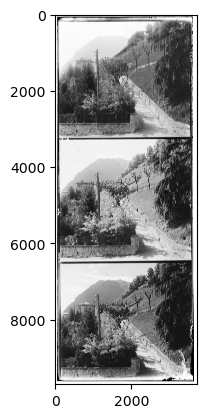

In [7]:
print(f"Shape: {stained_glass.shape}  Minimum: {stained_glass.min()}  Maximum: {stained_glass.max()}")

plt.imshow(stained_glass, cmap='gray')

## Data Preparation
Als eerste stap willen we de afbeeldingen in drie losse kanalen splitsen zodat we er mee kunnen werken. Omdat de code hiervoor wat complex is, krijg je deze van ons:

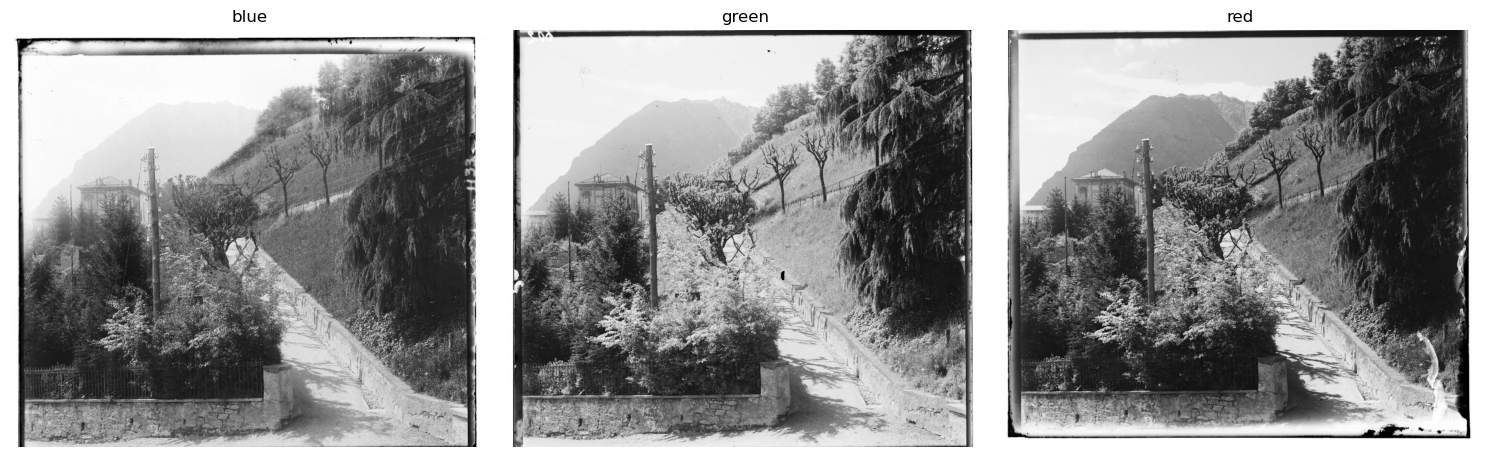

In [8]:
nrows = stained_glass.shape[0]
step = nrows // 3
skip = 4 # Skip some pixels
channels = (stained_glass[:step:skip, ::skip], stained_glass[step:2*step:skip, ::skip], stained_glass[2*step:3*step:skip, ::skip])
channel_names = ['blue', 'green', 'red']

fig, axes = plt.subplots(1, 3, figsize=(15,15), tight_layout=True)
for ax, image, name in zip(axes, channels, channel_names):
    _ = ax.imshow(image, cmap='gray')
    _ = ax.axis('off')
    _ = ax.set_title(name)

#### Opdracht
Voorzie de bovenstaande code van comments zodat de werking duidelijk is

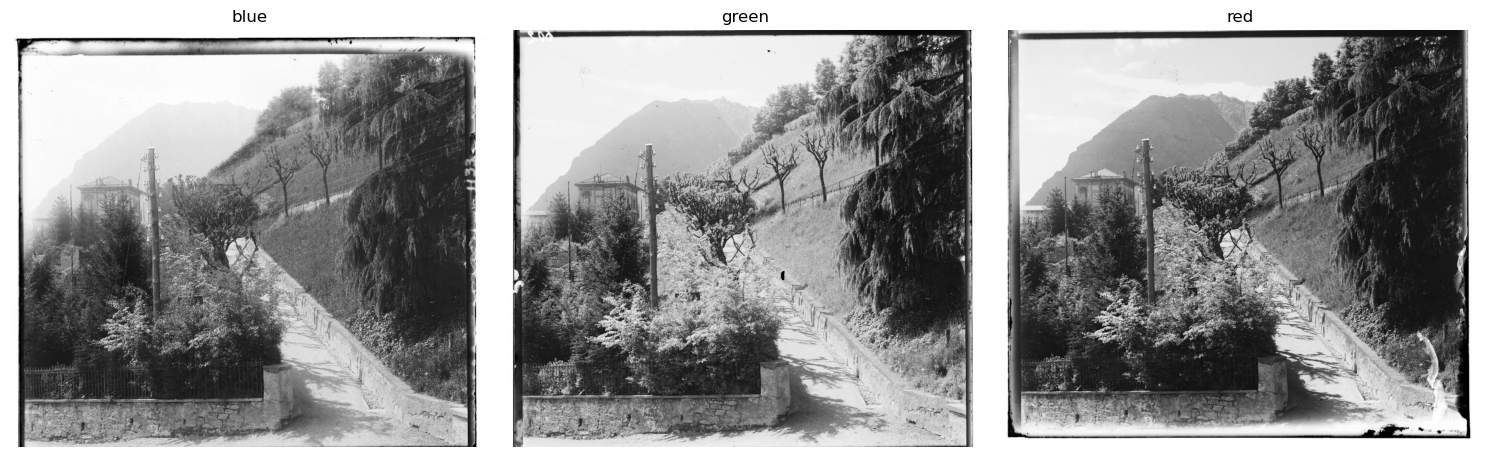

In [10]:
nrows = stained_glass.shape[0] # Aantal rijen in de image (y)
step = nrows // 3 # Afstand tussen de drie kanalen
skip = 4 # Skip some pixels
channels = (stained_glass[:step:skip, ::skip], stained_glass[step:2*step:skip, ::skip], stained_glass[2*step:3*step:skip, ::skip]) # Drie plaatjes maken
channel_names = ['blue', 'green', 'red'] # namen van kanalen die overeenkomen met de `channels`

fig, axes = plt.subplots(1, 3, figsize=(15,15), tight_layout=True) # Maak een figuur met 3 subplots
for ax, image, name in zip(axes, channels, channel_names):
    _ = ax.imshow(image, cmap='gray') # Toon de afbeelding
    _ = ax.axis('off') # Geen assen tonen
    _ = ax.set_title(name) # Toon de naam van het kanaal bovenaan de afbeelding

We hebben nu de drie losse afbeeldingen in een tuple zitten. Laten we de afbeeldingen nu gaan stapelen en onze eerste kleurenafbeelding maken.

#### Opdracht: 
- Combineer de drie kleurkanalen tot een RGB afbeelding. 
- Zorg er voor dat je de juiste kleurfiltervolgorde maakt.
- Hoe goed is de uitlijning van de afbeeldingen?

Hint: Maak gebruik van numpy.dstack

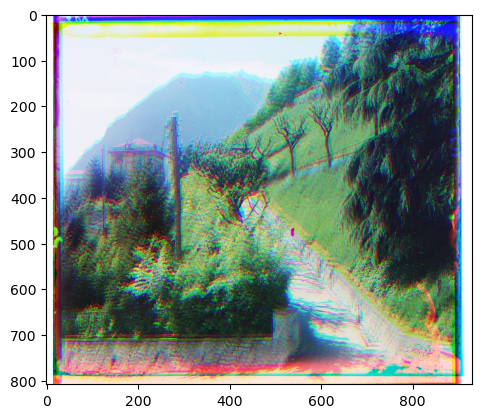

In [18]:
nrows = stained_glass.shape[0] # Aantal rijen in de image (y)
step = nrows // 3 # Afstand tussen de drie kanalen
skip = 4 # Skip some pixels

blue_chan = stained_glass[:step:skip, ::skip]
green_chan = stained_glass[step:2*step:skip, ::skip]
red_chan = stained_glass[2*step:3*step:skip, ::skip]

combined = np.dstack((red_chan, green_chan, blue_chan))
plt.imshow(combined)

## Modelling
We hebben nu de puzzelstukjes voor het uitlijnen van de afbeelding. We hebben nu een tweetal functies nodig. 
- De eerste verschuift een afbeeldingen met een $x$ en $y$ waarde (gecombineerd in één tuple genaamd _params_) en geeft vervolgens een afbeelding van hetzelfde formaat terug. In de code heet een verschuiving een _translation_. We noemen deze functie _shift\_image_.
- De tweede berekent de mean-squared-error tussen de afbeeldingen. Dit is dezelfde functie als in het eerste lesdeel
- Als derde een functie die als input de verschuif-parameters neemt plus de twee afbeeldingen. De functie verschuift de afbeelding eerst en berekent dan de MSE.

We geven je de eerste twee functies. De derde moet je zelf programmeren

#### Opdracht: 
Schrijf een functie _cost_ die:
- als input de waarden params, image1 en image2 neemt
- met behulp van shift_image de image2 verschuift op basis van params
- vervolgens de MSE als output geeft van image1 en de verschoven afbeelding

In [19]:
# Gegeven
def shift_image(params, original_image):

    tf = transform.EuclideanTransform(translation=params)

    return transform.warp(original_image, tf, order=3)

In [20]:
# Gegeven
def MSE(image1, image2):

    return np.sum((image1 - image2)**2)

In [22]:
def cost(params, image1, image2):
    new_image = shift_image(params, image2)
    return MSE(image1, new_image)

In [56]:
cost((0, 0), red_chan, green_chan)

39218.2032231441

#### Opdracht: Laat het brute-algoritme los op de blauwe en groene kanalen 
- Doe een brute-force voor alle waarden van de verschuiving van -30 naar 30.
- Hint: slice(-30,30,1)
- Zet als extra parameters voor brute full_output=True en finish=None
- Visualiseer vervolgens het cost-landscape? Is dit een global of local minimum probleem?
- Wat valt je op? Waar ligt het optimum? 

In [34]:
ranges = (
    slice(-30, 30, 1),
    slice(-30, 30, 1)
)
args = (red_chan, blue_chan)

brute_blue = brute(cost, ranges, args=args, full_output=True, finish=None)




ranges = (
    slice(-30, 30, 1),
    slice(-30, 30, 1)
)
args = (red_chan, green_chan)

brute_green = brute(cost, ranges, args=args, full_output=True, finish=None)

[0. 0.]


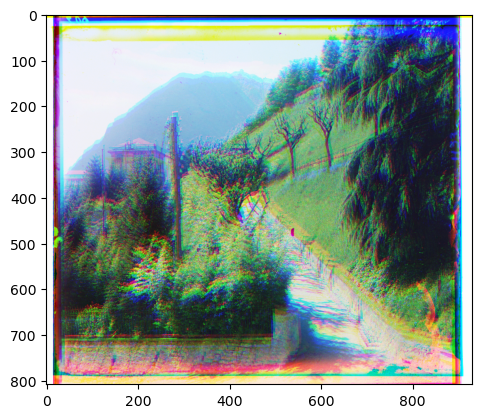

In [67]:
# Visualisatie
# print(brute_force_output)
print(brute_green[0])

# print("=============")
green_chan2 = shift_image(brute_green[0], green_chan)
blue_chan2 = shift_image((0, -8), blue_chan)

empty_chan = np.zeros(red_chan.shape)

combined = np.dstack((red_chan, green_chan2, blue_chan2))
plt.imshow(combined)

In [ ]:
# Plaats hier je uitwerking

## Evaluation

#### Opdracht
De oplossing lijkt (4,7) te zijn, maar er is een tweede dal op (0,0)? Is dat logisch? Wat kan de reden zijn voor deze twee dallen?

Hint: Plot een verschilkaart tussen de twee afbeeldingen. Verschuif één van de twee afbeeldingen met 10 pixels en plot opnieuw. Wat valt op?

In [ ]:
# Plaats hier je uitwerking

In [ ]:
# Plaats hier je uitwerking

### Verbetering: Alleen kijken naar het centrale gedeelte

#### Opdracht
Het is duidelijk dat er een probleem ontstaat door verschuivingen, 
omdat bij verschuivingen blanco pixels ontstaan die een heel grote RME gaan opleveren.
 
- Pas je cost_center functie aan, zodat het alleen naar het centrale deel van de afbeeldingen kijkt voor het berekenen van de MSE
- Test de nieuwe functie met de brute-methode en visualiseer het cost landscape
- Is het probleem nu een verbetering?

In [75]:
def cost_center(params, image1, image2):
    a = image1.shape[0] // 4
    b = image1.shape[1] // 4
    pad = 10

    image1 = image1[pad:-pad, pad:-pad]
    image2 = image2[pad:-pad, pad:-pad]

    new_image = shift_image(params, image2)

    return MSE(image1, new_image)


In [76]:
ranges = (
    slice(-30, 30, 1),
    slice(-30, 30, 1)
)
args = (red_chan, blue_chan)

brute_blue = brute(cost_center, ranges, args=args, full_output=True, finish=None)

In [78]:
ranges = (
    slice(-30, 30, 1),
    slice(-30, 30, 1)
)
args = (red_chan, green_chan)

brute_green = brute(cost_center, ranges, args=args, full_output=True, finish=None)

In [79]:
print(brute_blue[0])
print(brute_green[0])

[-8. 16.]
[-4.  9.]


## Definitieve afbeelding
We hebben een werkende aanpak gevonden met de centrale methode. Laten we de techniek gaan gebruiken om de definitieve afbeelding te maken.

#### Opdracht
Nu we een goede methode hebben ontwikkeld, is het tijd om de afbeelding te maken
- Bereken nog eenmaal de verschuivingen voor de combinaties blauw-groen en blauw-rood
- Maak hiervoor gebruik van de brute functie uit scipy.optimize
- Toon het eindplaatje als een RGB afbeelding

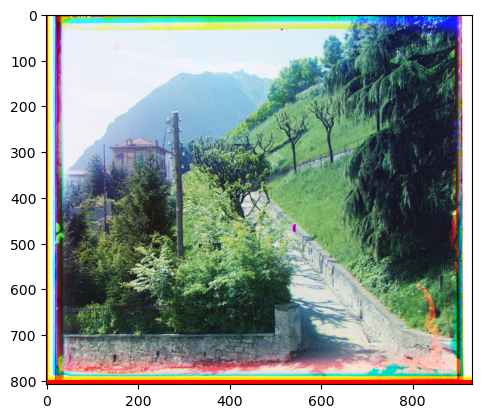

In [80]:
blue_chan2 = shift_image((-8, 16), blue_chan)
green_chan2 = shift_image((-4, 9), green_chan)

empty_chan = np.zeros(red_chan.shape)

combined = np.dstack((red_chan, green_chan2, blue_chan2))
plt.imshow(combined)

In [ ]:
# Plaats hier je uitwerking

In [ ]:
# Plaats hier je uitwerking

## Bronvermelding:
<ul>
    <li><a href="https://loc.gov/collections/prokudin-gorskii/about-this-collection/">Library of Congress</a></li>
    <li><a href="https://en.wikipedia.org/wiki/History_of_photography">Wikipedia</a></li>
</ul>